In [1]:
# https://www.youtube.com/watch?v=q_HS4s1L8UI

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

DATA_PATH = '../../data/AMZN.csv'
data = pd.read_csv(DATA_PATH)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [2]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500
6515,2023-04-05,103.910004,103.910004,100.750000,101.099998,101.099998,45103000


In [8]:
df = data[['Date','Close']].copy()
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

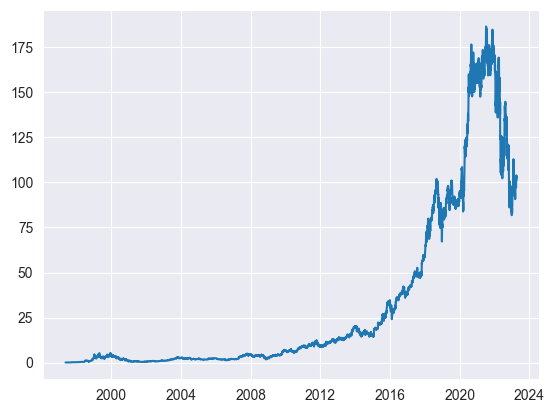

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])
plt.show()

In [11]:
from copy import deepcopy

def prepare_dataframe(input_df, num_steps):
    _df = deepcopy(input_df) # 创建输入DataFrame的深拷贝，避免修改原始数据
    _df['Date'] = pd.to_datetime(_df['Date'])
    _df.set_index('Date', inplace=True)
    for s in range(1, num_steps+1):
        _df[f'Close(t-{s})'] = _df['Close'].shift(s)
    _df.dropna(inplace=True) # 删除包含NaN值的行（由于shift操作，前几行会产生NaN）
    return _df

lookback = 7
shifted_df = prepare_dataframe(df, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [12]:
shifted_df_np = shifted_df.to_numpy()
print(shifted_df_np[:5])

[[0.079167 0.075    0.069792 0.071354 0.081771 0.085417 0.086458 0.097917]
 [0.076563 0.079167 0.075    0.069792 0.071354 0.081771 0.085417 0.086458]
 [0.07526  0.076563 0.079167 0.075    0.069792 0.071354 0.081771 0.085417]
 [0.075    0.07526  0.076563 0.079167 0.075    0.069792 0.071354 0.081771]
 [0.075521 0.075    0.07526  0.076563 0.079167 0.075    0.069792 0.071354]]


In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)
print(shifted_df_np[:5])

[[-0.99991063 -0.99995531 -1.         -0.99998325 -0.99987154 -0.99983244
  -0.99982128 -0.99969839]
 [-0.99993855 -0.99991063 -0.99994415 -1.         -0.99998325 -0.99987154
  -0.99983244 -0.99982128]
 [-0.99995253 -0.99993855 -0.99989946 -0.99994415 -1.         -0.99998325
  -0.99987154 -0.99983244]
 [-0.99995531 -0.99995253 -0.99992739 -0.99989946 -0.99994415 -1.
  -0.99998325 -0.99987154]
 [-0.99994973 -0.99995531 -0.99994136 -0.99992739 -0.99989946 -0.99994415
  -1.         -0.99998325]]


In [16]:
# features = [Close(t-1), Close(t-2), ..., Close(t-7)]
# label = Close
x = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]
x.shape, y.shape

((6509, 7), (6509,))

In [18]:
TRAIN_RATIO = 0.95
train_size = int(TRAIN_RATIO * x.shape[0])
x_train = x[:train_size]
x_valid = x[train_size:]
y_train = y[:train_size]
y_valid = y[train_size:]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((6183, 7), (6183,), (326, 7), (326,))

In [19]:
# 适配时间序列模型的输入格式
x_train = x_train.reshape(-1, lookback, 1)
x_valid = x_valid.reshape(-1, lookback, 1)
y_valid = y_valid.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((6183, 7, 1), (6183, 1), (326, 7, 1), (326, 1))

In [20]:
x_train = torch.as_tensor(x_train).float()
y_train = torch.as_tensor(y_train).float()
x_valid = torch.as_tensor(x_valid).float()
y_valid = torch.as_tensor(y_valid).float()
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([6183, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([326, 1]))

In [21]:
from torch.utils.data import DataLoader, Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(x_train, y_train)
valid_dataset = TimeSeriesDataset(x_valid, y_valid)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
for batch in train_loader:
    x_batch, y_batch = batch
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [25]:
# 时间序列模型
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        bsize = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, bsize, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, bsize, self.hidden_size)
        out, (h, c) = self.lstm(x, (h0, c0)) # out.shape = (batch_size, sequence_length, hidden_size)
        # out[:, -1, :]提取每个样本在最后一个时间步的隐藏状态
        # out[:, -1, :].shape = (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1).to(DEVICE)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
    model.train()
    print(f'Epoch: {epoch+1}')
    running_loss = 0.0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = loss_fn(logits, y)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 99: # print every 100 batches
            avg_loss = running_loss / 100
            print(f'Batch {batch_idx+1}, loss: {avg_loss:.3f}')
            running_loss = 0.0

In [ ]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
for epoch in range(NUM_EPOCHS):
    train_one_epoch()
    valid_one_epoch()